---
title: "GPT from scratch"
author: "Suchith Prabhu"
date: "2023-03-05"
jupyter: python3
image: "images/thumbnail.png"
sidebar: false

---

Language models have become increasingly popular in recent times. People are using it for various purposes, including information retrieval, language assistance and code generation. These models are very powerful and represent an engineering marvel of the century. We have come a long way from research projects to something that people could use in their daily lives. The basic building blocks and idea behind these models are simple, and with libraries like Pytorch, coding them from scratch would not take much time. It is a straightforward concept that has been scaled to such a massive degree that it performs exceptionally well. In this post, we will go through the steps to building GPT, which is a decoder-only transformer architecture. Throughout this process, we will see that it is not much different from the Bigram language model, with the addition of a few communication and computation layers. While going through this post, you might feel like GPT is based on straightforward ideas that you could have come up with, but it is the result of a decade of rigorous empirical work that has made it a reality.

Prior to delving into transformer architecture, it would be advantageous to begin with the bigram model and subsequently extend the concept with new architectural techniques.

The following code will aid in importing the required modules. We will only be utilizing essential functions from these modules to construct the model from the ground up.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Load Data

We will be utilizing the `tiny_shakespeare` dataset, which consists of 40,000 lines of Shakespeare from a variety of his plays. This is an excellent starting point, and we will keep track of the text generated by our language model as we continue to improve it. It will be surreal to observe our model ultimately generating Shakespearean text.

We proceed to read the text data.

In [2]:
data_file = "./input.txt"

with open(data_file, 'r', encoding="utf-8") as file:
    content = file.read()

The first 1000 characters from the file are as follows:

In [4]:
#| echo: false
#| panel: input

print(content[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



The file contains 1,115,394 characters which we will use for training.

In [6]:
#| echo: false
#| output: false
print(f"Number of characters : {len(content)}")

Number of characters : 1115394


We will train a character-level language model, meaning that our model will output one character at a time to generate a sentence. We will keep it simple to ensure we have a clear understanding and avoid getting entangled in complex engineering decisions.

In [5]:
#| echo: false
#| output: false
characters = sorted(list(set(content)))
vocab_size = len(characters)
print(f"Vocabulary size : {len(characters)}")

Vocabulary size : 65


In [11]:
#| echo: false
#| output: false
"".join(characters)

"\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

With this, we have a vocabulary size of 65, and the different characters in our dataset are:

`"\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"`

We then tokenize the text by mapping each character to a corresponding number that can be utilized by the model, as the model solely manipulates numbers. This is a common practice in machine learning. Additionally, we split our dataset into training and testing sets, which is also a common practice in machine learning to measure generalization, as that is all that we care about.

In [6]:
stoi = { c:i for i, c in enumerate(characters)}
itos = { i:c for i, c in enumerate(characters)}

encode = lambda s: [stoi[c] for c in s]
decode = lambda x: "".join([itos[i] for i in x])


# Train-test split
data = torch.tensor(encode(content), dtype=torch.long)
n_train = int(0.9*len(data))
train_data = data[:n_train]
valid_data = data[n_train:]

Below is a sneak-peek into the training data, in tokenized and text forms.

In [7]:
#| echo: false
#| panel: input
print(train_data[100:200])

tensor([ 1, 39, 56, 43,  1, 39, 50, 50,  1, 56, 43, 57, 53, 50, 60, 43, 42,  1,
        56, 39, 58, 46, 43, 56,  1, 58, 53,  1, 42, 47, 43,  1, 58, 46, 39, 52,
         1, 58, 53,  1, 44, 39, 51, 47, 57, 46, 12,  0,  0, 13, 50, 50, 10,  0,
        30, 43, 57, 53, 50, 60, 43, 42,  8,  1, 56, 43, 57, 53, 50, 60, 43, 42,
         8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0,
        18, 47, 56, 57, 58,  6,  1, 63, 53, 59])


In [8]:
#| echo: false
#| panel: input
decode(train_data[100:200].tolist())

' are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you'

# Batching

The function provided below will return a batch of datasets. It is essential to clarify two hyperparameters that play a significant role in this process:

* __block_size__: This parameter defines the continuous piece of text that we will consider in the language modeling task.
* __batch_size__: This parameter determines the number of blocks of text that we will process in parallel by passing them through the network to compute the loss function, which measures the quality of weight parameters.

We create a batch by randomly selecting `batch_size` indices in the text corpus and then stacking together contiguous blocks of text of length `block_size`.

Our objective in the bigram language model is to predict the subsequent word solely using the preceding word.

In [7]:
block_size = 8
batch_size = 32

In [8]:
def get_batch(split):
    data = train_data if split == "train" else valid_data
    idxs = torch.randint(len(data)-block_size, size=(batch_size,))
    x = torch.stack([data[idx:idx+block_size] for idx in idxs])
    y = torch.stack([data[idx+1:idx+block_size+1] for idx in idxs])
    x, y = x.to(device), y.to(device)
    return x, y

This function facilitates obtaining a more precise estimate of the loss because when training, we compute the loss over the mini-batch, which may not be an excellent representation of loss for `eval_interval` number of iterations of the training.

In [9]:
eval_iters = 200

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## Bigram Language Model

We construct an embedding for each character in the vocabulary with the same dimension as the size of the vocabulary. Each entry denotes the unnormalized log-probabilities of the next character given the current character. We model this such that we minimize the cross-entropy loss to learn this probability distribution. The diagram below provides a better explanation of this process.

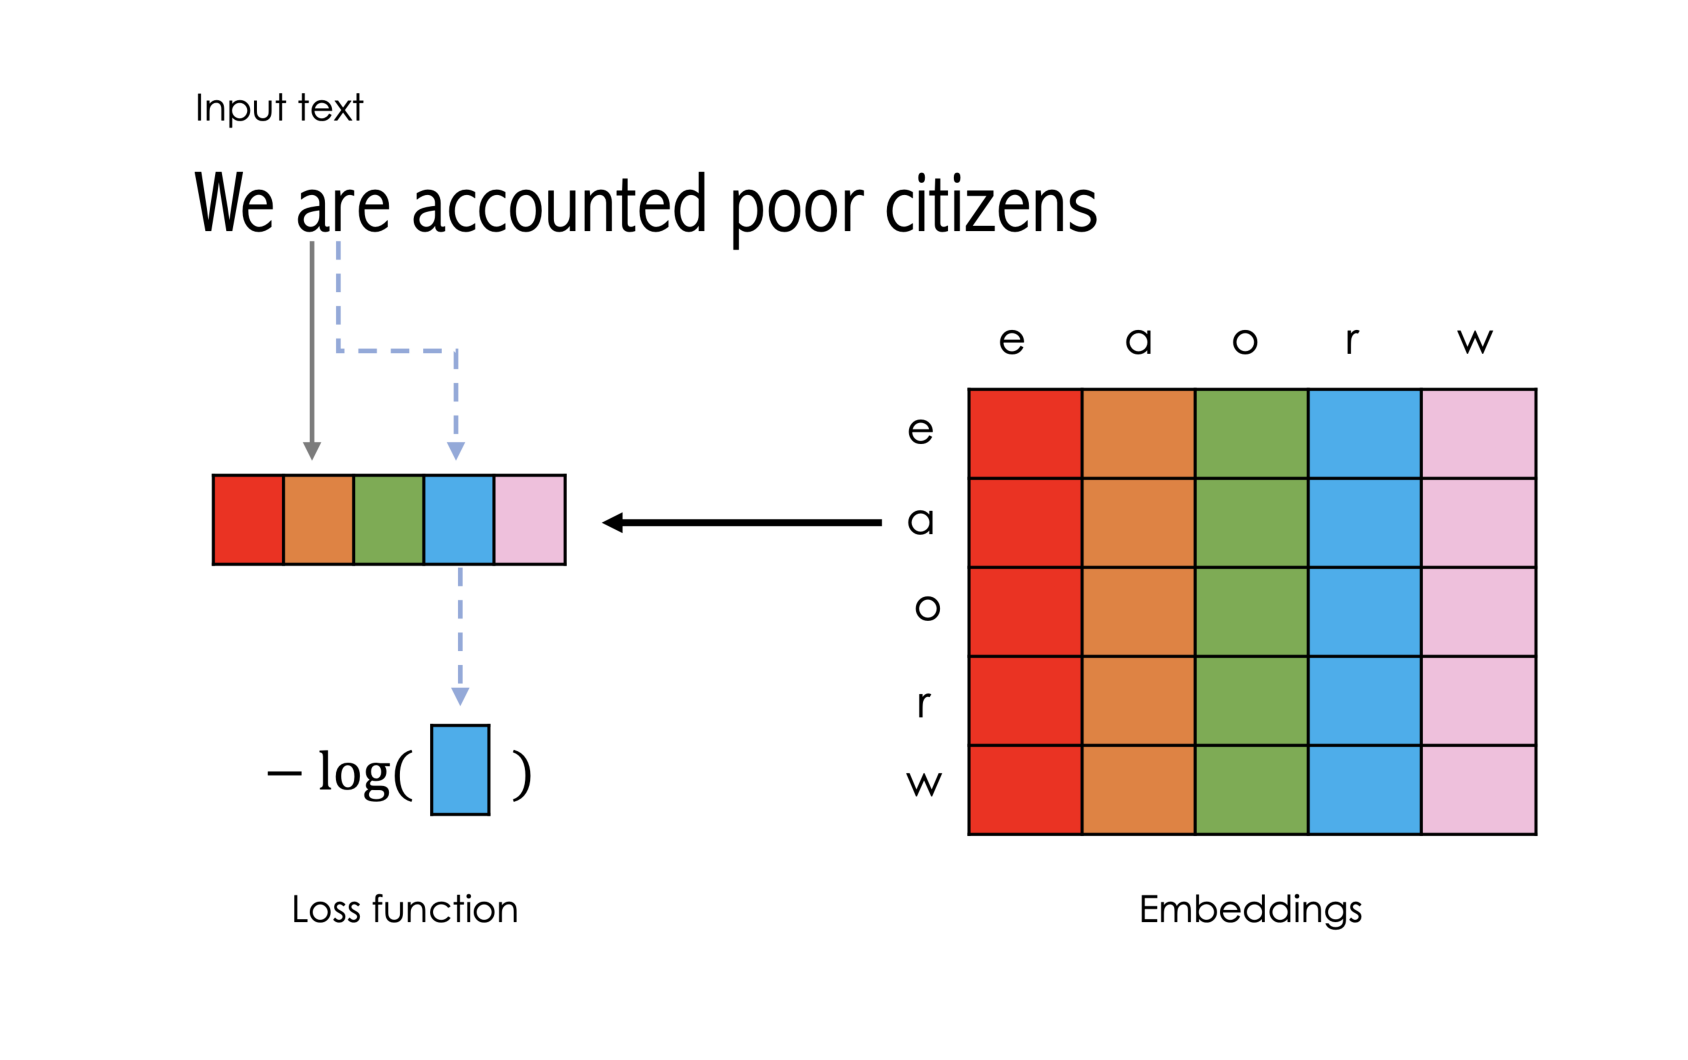

In [25]:
#| label: fig-bigram
#| fig-cap: Bigram Model
#| echo: false

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
plt.axis('off')
plt.imshow(plt.imread("bigram_2.png"))
plt.show()

Code for the Bigram language model.

In [13]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super(BigramLanguageModel, self).__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x, y=None):
        logits = self.token_embedding_table(x) # (B,T,C)

        if y is None:
            loss = None
        else:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), y.view(B*T))

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens):

        for _ in range(max_new_tokens):
            logits, _ = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=-1)
        return idx

To generate a new sequence from the trained model, we sample characters from the learnt distribution.

We have created the `BigramLanguageModel` object below.

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = BigramLanguageModel(vocab_size)
model = model.to(device)

Here is the text generated by the model before training.

In [21]:
#| panel: input
#| echo: false
#print("Text generated before training : ")
context = torch.zeros((1, 1), dtype=torch.long, device=device)
out = model.generate(context, max_new_tokens=500)
print(decode(out.squeeze().tolist()))


U3x
UFcbptwyzsjOLyg3b.vBQC;TdZMxr?q KPe&:MMEhOotlJI.'gv?lq
FNzXFGklQuRkftks-3bop&g.IIe-lkTDZ$zC;wTbApsBjDKRU.i;XlaOVmujKoWmn 3IFSwVxKM
jhIcITo
YqlXhauIREGcjN;avU3blg,?b$-;fIGKropZjhGOxSn npFYX!n;v;F FtE?cnhfziNCi3T!
LuhDXnpm,MH& X'ROuDLxguACkEppAkX!MvAhxSI&gF! vuauPqijhxrqJyS$z-3VmVmB,CRXwWl'Tn cgnVN $VAWgU:a&RseCjvW,BcbSjJPzZl
jr'kO byOr.bDaMLJxcoyl
3hPulOyOd
3taQAYcl&tvPcsi&JPE!Sr,-GVkNxBqHKJPAk&GSDOXVE,rA:aGt
FS,l'aLhyUa:HuRc Jp,pqzXWH,h:r?OLoJ!iYJPcMKGfNPnHMMllxHPEjVkY-3TdZQJmuLvuv;stHZdwsrt


The generated text looks like gibberish and does not resemble human writing. The words are very long, as if the characters have been randomly sampled. Let's see how the text looks after training.

Below is the code for training the model.

In [22]:
# hyperparameters
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = "cuda" if torch.cuda.is_available() else "cpu"


optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for i in range(max_iters):
    if i % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {i:04d}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0000: train loss 4.6909, val loss 4.6764
step 0300: train loss 2.8011, val loss 2.8099
step 0600: train loss 2.5521, val loss 2.5599
step 0900: train loss 2.5008, val loss 2.5132
step 1200: train loss 2.4754, val loss 2.5033
step 1500: train loss 2.4693, val loss 2.5059
step 1800: train loss 2.4643, val loss 2.4828
step 2100: train loss 2.4703, val loss 2.4907
step 2400: train loss 2.4656, val loss 2.4919
step 2700: train loss 2.4575, val loss 2.4904


This is the text generated by the model after training the Bigram model.

In [23]:
#| panel: input
#| echo: false
#print("Text generated after training : ")
context = torch.zeros((1, 1), dtype=torch.long, device=device)
out = model.generate(context, max_new_tokens=500)
print(decode(out.squeeze().tolist()))


Why th T:
Tonof ne h furst w:
An h, gie choid welleintrs a wawis LARKETomug!

I welom fohe! da RD:
ULindeye tor, our barand bea nt, t brkifaind asithald So het
D:
Tham o d! Hist.
I okngorde andixis hlimends berseiayord Ansthurdous sowhays mecctoncereltougan!'CAnd
Thalou,

I cihe !
D:

TINToutheanere thx.
Nourm nd anoseshad thood
F tounds t and, am, lofoupit qur ime foung st ns sishout, d In cof, tat tolll mpitorised??

And arruldoid d ve, o wsetorco le RDid.
Fifr wentooy ween:
Whay, that E chald


After training, the generated text looks more like human writing, but the words still do not make any sense. However, we have made progress.

# Generative Pre-trained Transformer

The figure presented below provides an explanation of the self-attention mechanism that serves as the primary ingredient of the GPT model. This mechanism can be considered as the communication component that renders the GPT model highly effective.

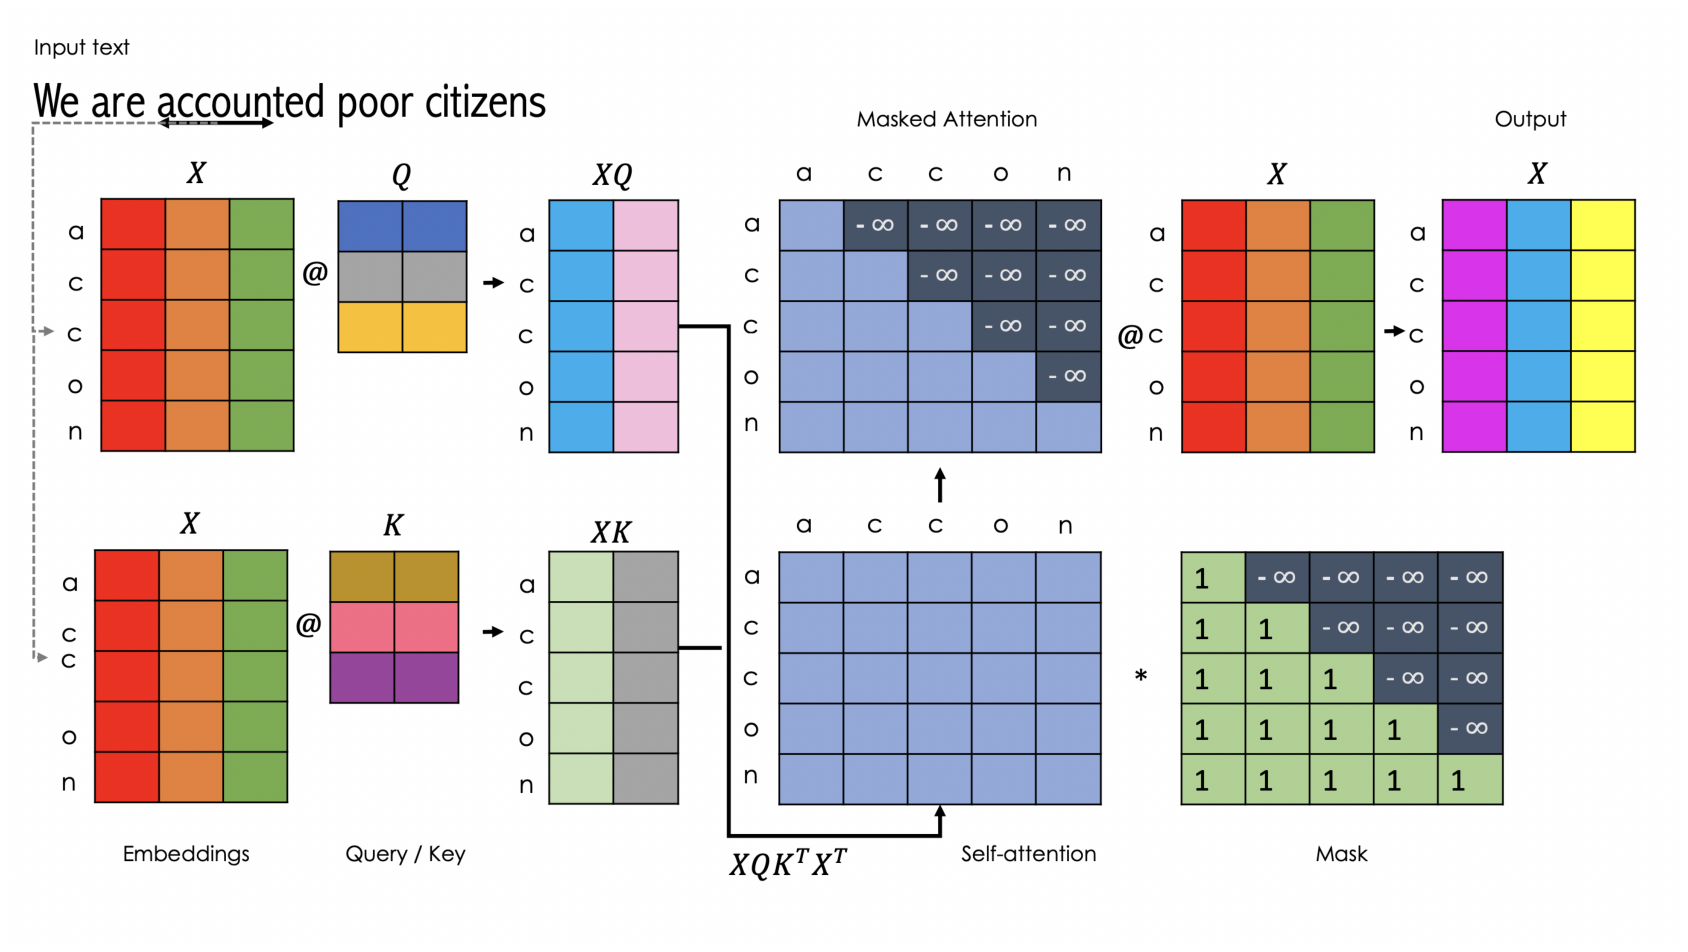

In [26]:
#| label: fig-gpt1
#| fig-cap: Masked Attention Mechanism
#| echo: false

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
plt.axis('off')
plt.imshow(plt.imread("images/decoder_attention.png"))
plt.show()

The `head` class, as shown below, implements the masked self-attention, given that our language model predicts the subsequent word based on all preceding words. Hence, we should not be able to access words that appear later in the sentence.

In [10]:
class Head(nn.Module):

    def __init__(self, head_size):
        super(Head, self).__init__()

        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, embed):
        k = self.key(embed)   # B,T,n_hd
        q = self.query(embed) # B,T,n_hd

        B, T, H = k.shape
        weight = q @ k.transpose(-1, -2)*(H**-0.5) # B,T,T
        weight = weight.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        weight = F.softmax(weight, dim=-1) # B, T, T
        weight = self.dropout(weight)

        v = self.value(embed)
        out = weight @ v
        return out

Multihead attention, as applied in this context, leverages the attention mechanism multiple times before concatenating the outputs and passing them through a fully connected layer that yields the final output.

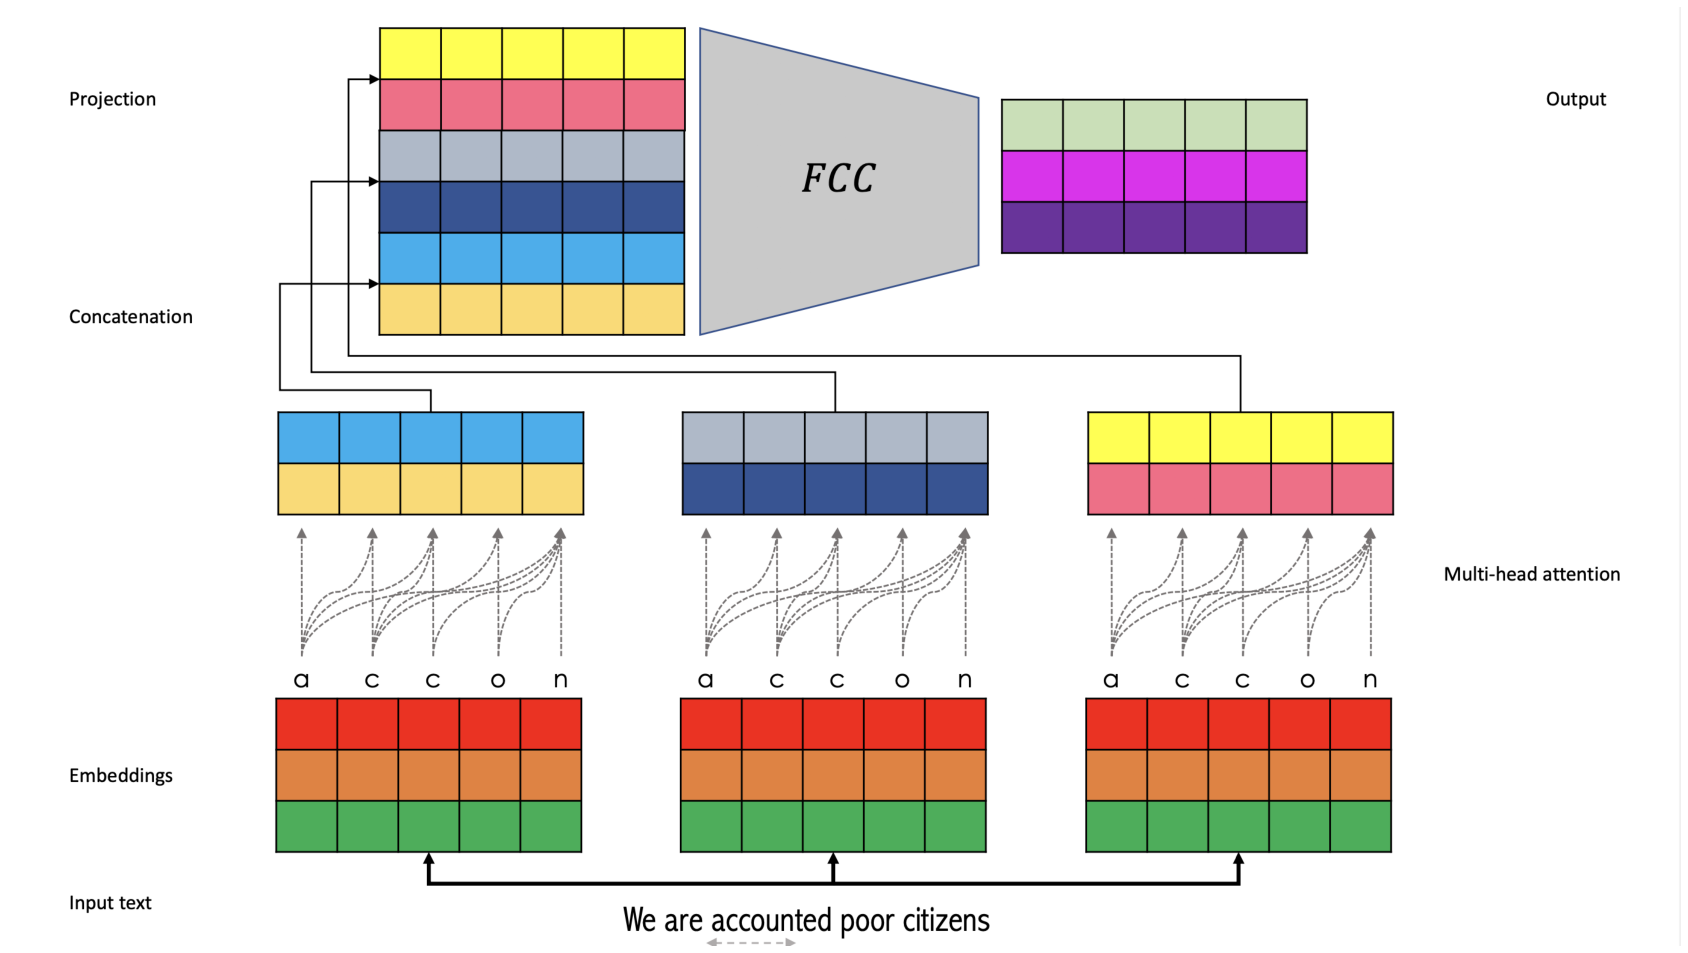

In [46]:
#| label: fig-gpt2
#| fig-cap: Multi-head Attention Mechanism
#| echo: false

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
plt.axis('off')
plt.imshow(plt.imread("images/multi_head_attention.png"))
plt.show()

In [11]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super(MultiHeadAttention, self).__init__()

        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads*head_size, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embed):
        out = torch.cat([h(embed) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))

The normal fully connected layer, depicted below, projects the embedding to a higher dimension before projecting it back to the original space. This component serves as the computation component of the architecture.

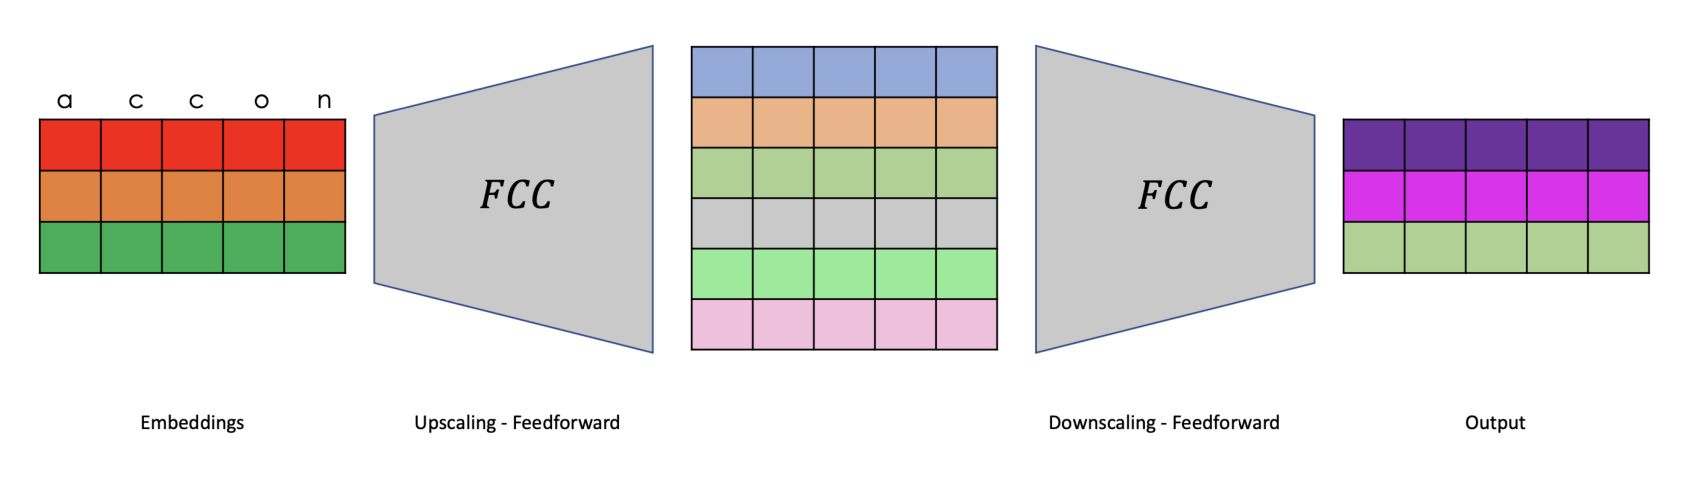

In [28]:
#| label: fig-gpt3
#| fig-cap: Feedforward Mechanism
#| echo: false

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
plt.axis('off')
plt.imshow(plt.imread("images/feedforward.png"))
plt.show()

The class presented below implements the feedforward network.

In [12]:
class FeedForward(nn.Module):

    def __init__(self):
        super(FeedForward, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_embed, 4*n_embed),
            nn.ReLU(),
            nn.Linear(4*n_embed, n_embed),
            nn.Dropout(dropout)
        )

    def forward(self, embed):
        return self.net(embed)

The decoder block, which consists of the aforementioned multi-head attention and feedforward network, along with the residual connections and layer norm, is shown here.

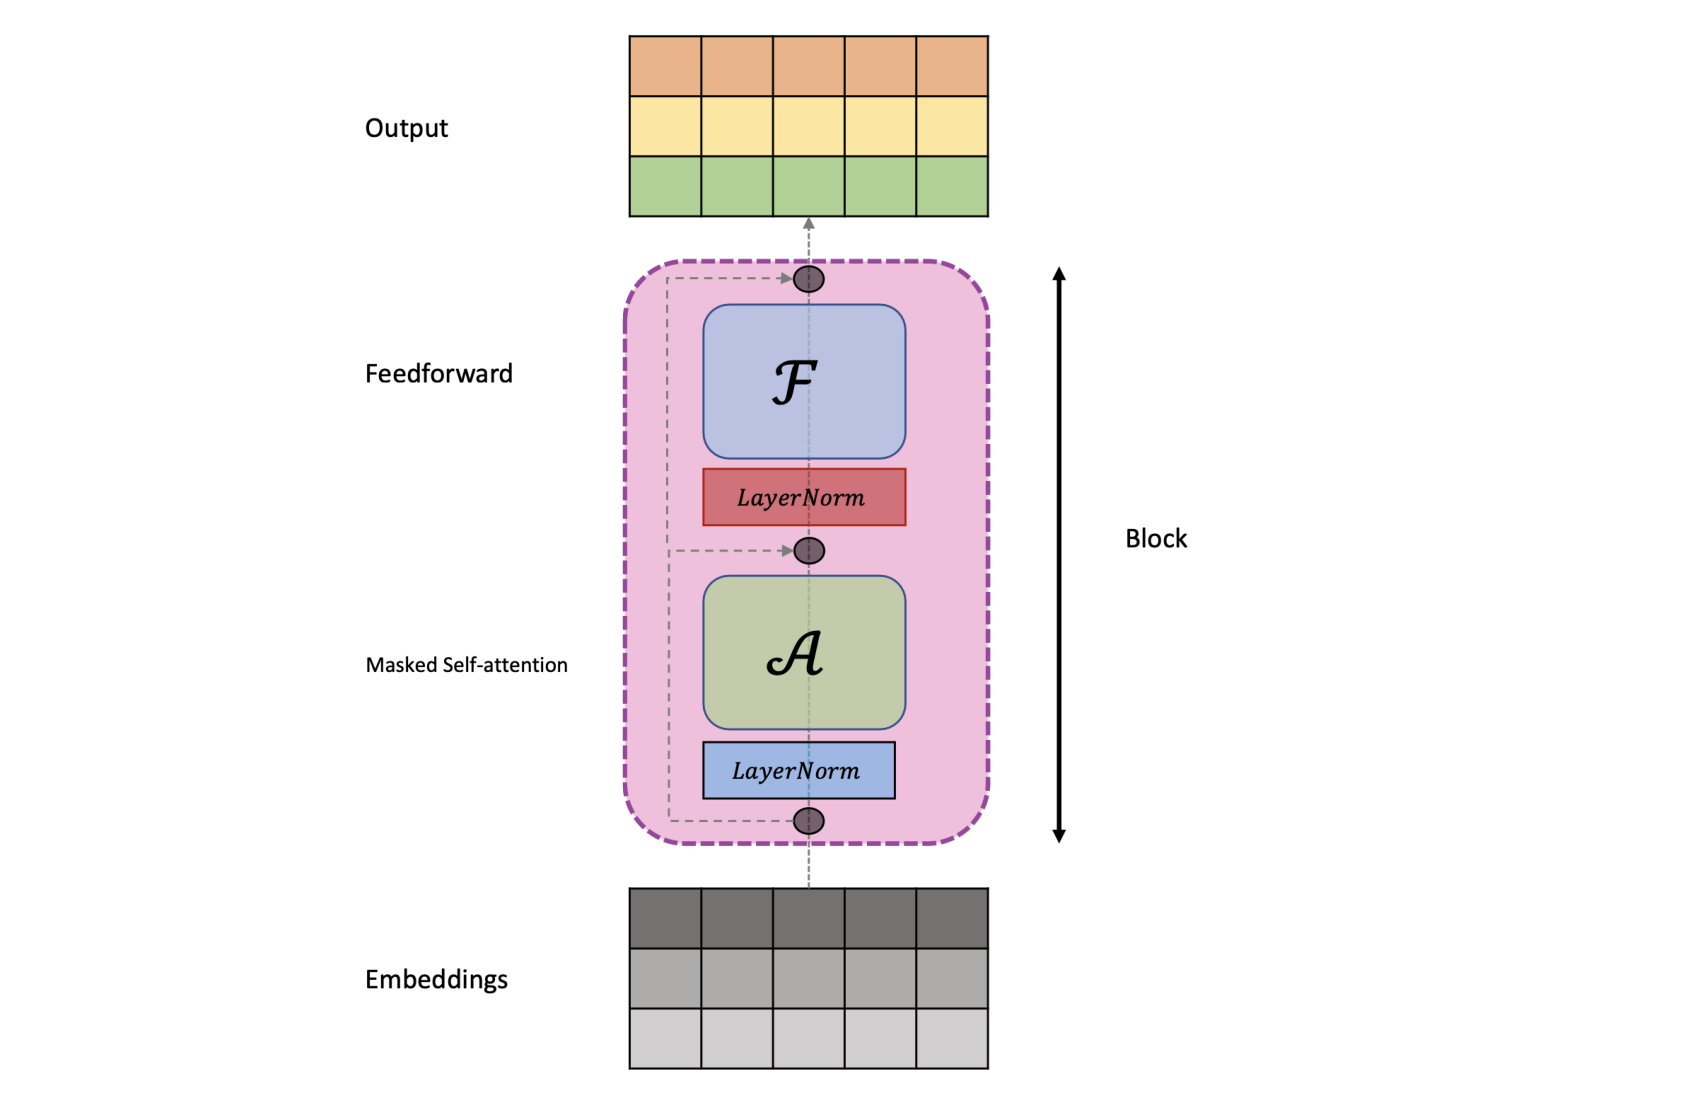

In [52]:
#| label: fig-gpt4
#| fig-cap: Block
#| echo: false

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
plt.axis('off')
plt.imshow(plt.imread("images/block.png"))
plt.show()

The class presented below implements the GPT block.

In [13]:
class Block(nn.Module):

    def __init__(self, num_heads):
        super(Block, self).__init__()

        head_size = n_embed//num_heads
        self.sa = MultiHeadAttention(num_heads, head_size)
        self.ff = FeedForward()
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

Multiple such decoder blocks, mentioned above, are stacked one after the other to create the decoder model.

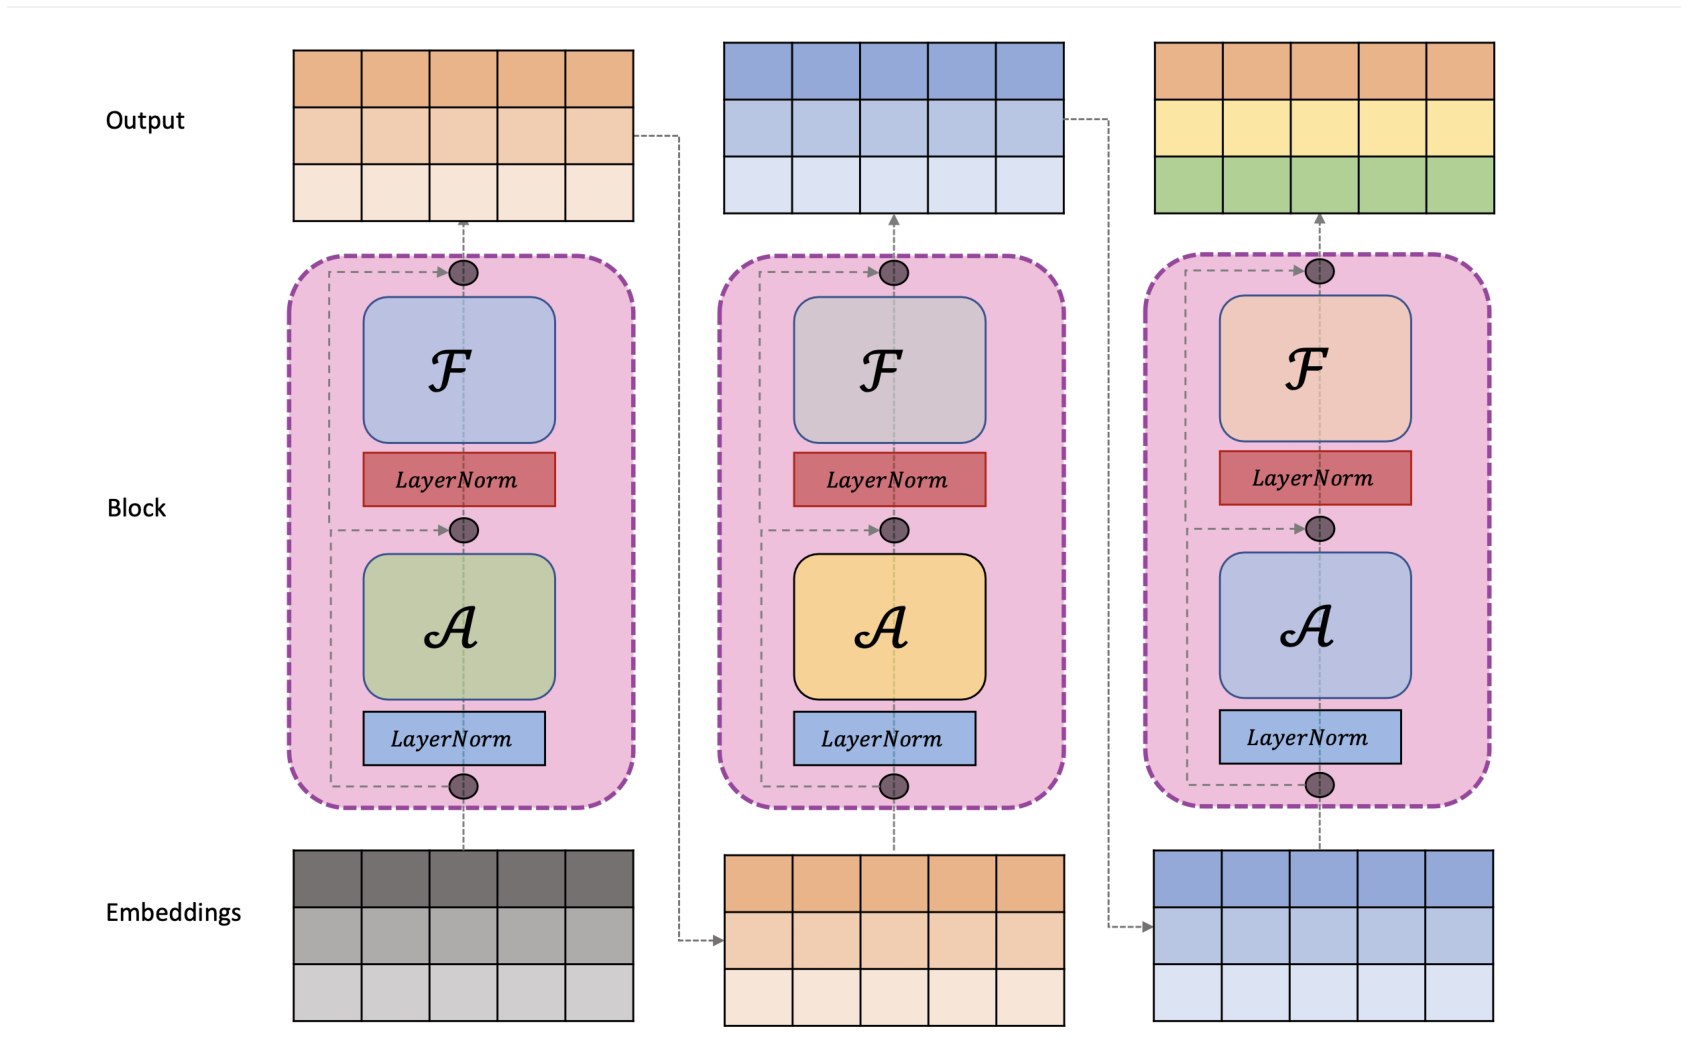

In [43]:
#| label: fig-gpt5
#| fig-cap: GPT Architecture
#| echo: false

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
plt.axis('off')
plt.imshow(plt.imread("images/decoder.png"))
plt.show()

The code for the GPT language model is presented below.

In [14]:
class GPTLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super(GPTLanguageModel, self).__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(*[Block(n_heads) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_embed = self.token_embedding_table(idx) # (B,T,C)
        pos_embed = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        embed = tok_embed + pos_embed

        x = self.blocks(embed)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(B*T, -1), targets.view(-1))

        return logits, loss


    @torch.no_grad()
    def generate(self, idx, max_new_tokens):

        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=-1)
        return idx

The following are hyperparameters of the model:

* `n_embed`: This hyperparameter refers to the size of the embedding that is provided as input to the model.

* `n_heads`: This hyperparameter determines the number of heads that are present in the multi-head attention mechanism.

* `n_layers`: This hyperparameter represents the number of layers that are present in the decoder architecture.

In [27]:
learning_rate = 1e-5
eval_interval = 500
max_iters = 10_000
eval_iters = 200

n_embed = 384
n_layers = 6
n_heads = 6
dropout = 0.2

In [23]:
#| echo : false
import os

model_file = "models/gpt.pth"
checkpt_file = "checkpoints/gpt.tar"

os.makedirs(os.path.dirname(model_file), exist_ok=True)
os.makedirs(os.path.dirname(checkpt_file), exist_ok=True)

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = GPTLanguageModel(vocab_size)
model = model.to(device)

The output of the language model before training appears as gibberish, similar to the bi-gram language model.

In [25]:
#| panel: input
#| echo: false
#print("Before training : ")

context = torch.zeros((1, 1), dtype=torch.long, device=device)
out = model.generate(context, max_new_tokens=500)
print(decode(out.squeeze().tolist()))


.GvcnaF xX:$h&MoqZ':GEAlKNJoi;A!i&HC-AnKjWfm
vSbNKwitbBC
PFz'lLBw:iJVGzS?K:CiZmKqV'f$rYniedBHqYPVjL!!fOeJ,!?D-gA.xyLyKOXyQqBV$:YVVeNjZ.AwuSy$,GjFt: W!!&GNL
KXebzOkV;HwZ,xDAL3:SqyAzyzI &VLMbYCimDOnhXNzcMyseZvsZ'M-
NPix
&M?& ebnP&PgRSsATv;jZ$GQOI?nB;rlyP
QLaB;'JZ'yy,x. U
R&PhwiPe ,N H3L;j
AAg& QOKwH-L?jkSqrv
q,Jio:&,vGQ!?'f?AzGRfkjrKS kGo;$vviYBzoY!lW;NBUByt&.I:X.z$ywiMgqNSE&sxet-STdif
Ic LD-YNSgyQECJftXn!sDLvrpVNzbBkVh
VqBoIogYoZ qJcQeC,RIY!rVpVVy'Z'HJ:hNS:S!BOVqNGe-!$J&q:YyYJvVns:.eAM-zlQHRdsS;?


To train the language model where each word can only attend to its previous characters, and the output of the model corresponds to the next character, we utilize cross-entropy loss.

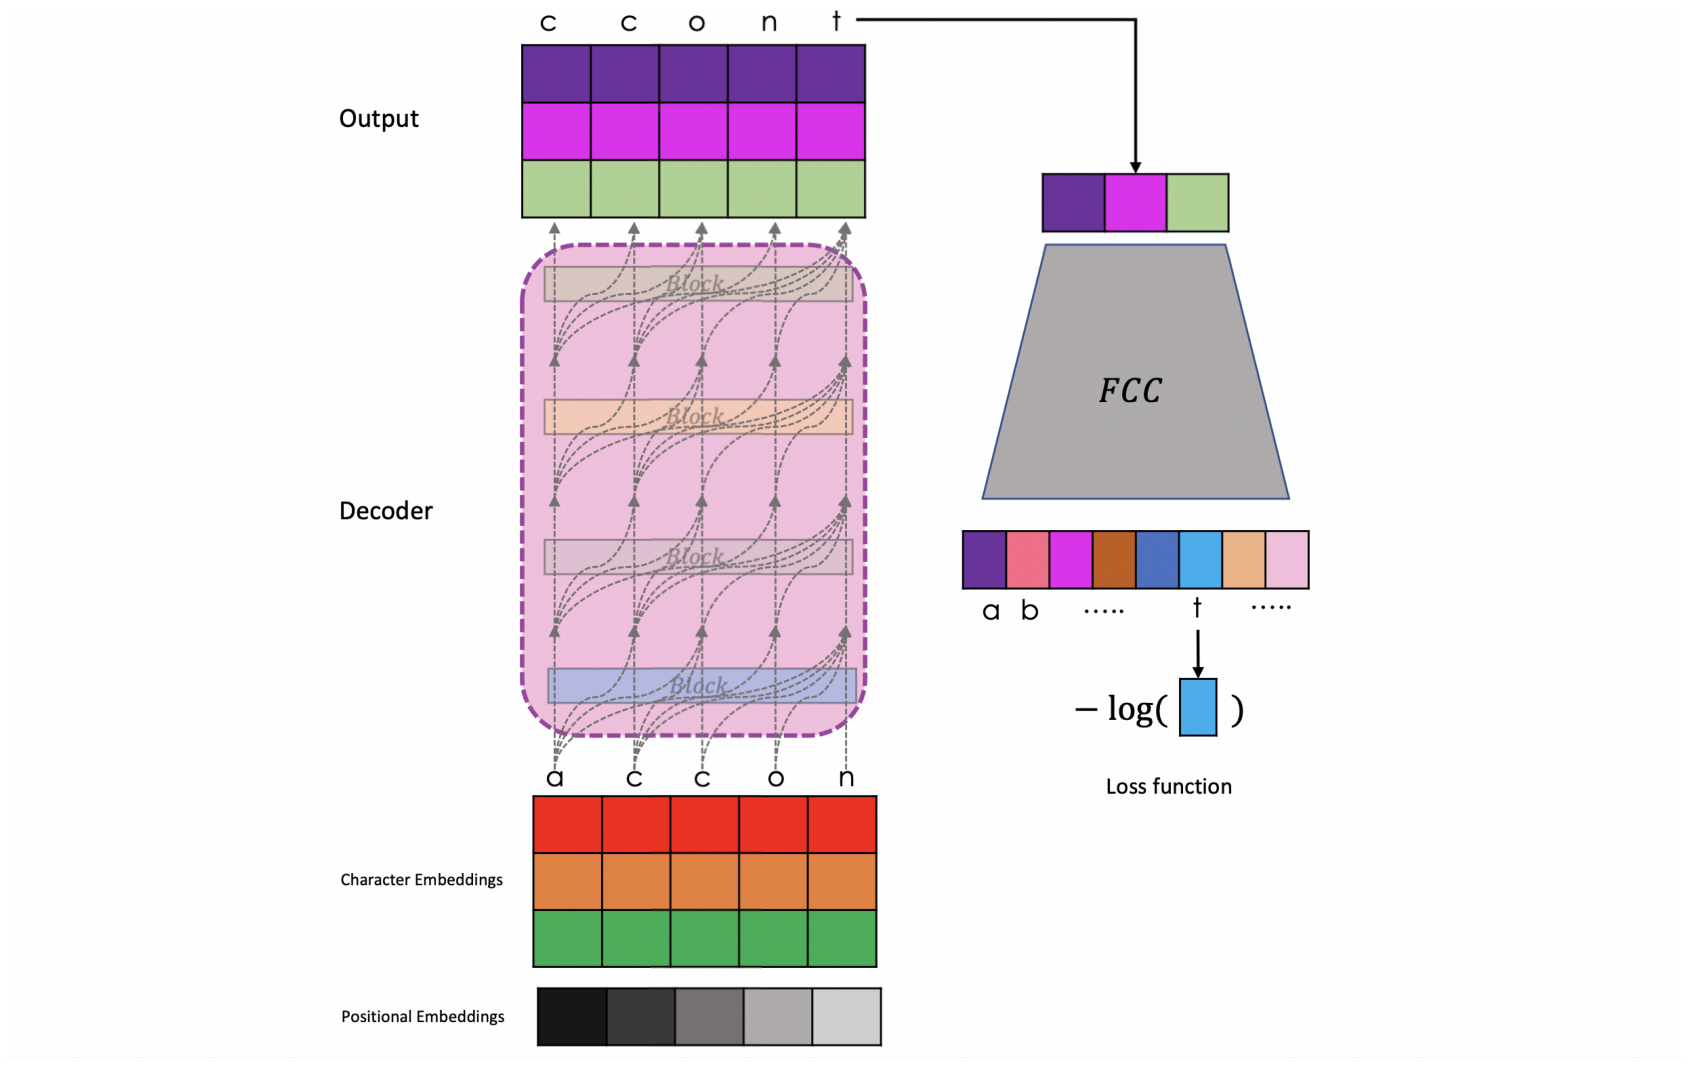

In [61]:
#| label: fig-gpt6
#| fig-cap: Training Process
#| echo: false

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
plt.axis('off')
plt.imshow(plt.imread("images/training.png"))
plt.show()

The code presented below implements the training procedure.

In [29]:
# Training model
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for i in range(max_iters):
    if i % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {i:04d}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        # Saving checkpoints
        torch.save({ 
                    "model_state_dict": model.state_dict(),
                    "optim_state_dict": optimizer.state_dict(),
                    "losses": losses,
                    "step": i
                    }, checkpt_file)

    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


# Saving model
torch.save({ 
            "model_state_dict": model.state_dict(),
            "optim_state_dict": optimizer.state_dict(),
            "losses": losses,
            }, model_file)

step 0000: train loss 4.2929, val loss 4.2965
step 0500: train loss 2.6520, val loss 2.6486
step 1000: train loss 2.4893, val loss 2.4732
step 1500: train loss 2.3979, val loss 2.3927
step 2000: train loss 2.3333, val loss 2.3421
step 2500: train loss 2.2838, val loss 2.2945
step 3000: train loss 2.2501, val loss 2.2572
step 3500: train loss 2.2217, val loss 2.2286
step 4000: train loss 2.1936, val loss 2.2161
step 4500: train loss 2.1471, val loss 2.1920
step 5000: train loss 2.1402, val loss 2.1732
step 5500: train loss 2.1237, val loss 2.1462
step 6000: train loss 2.1013, val loss 2.1450
step 6500: train loss 2.0873, val loss 2.1307
step 7000: train loss 2.0721, val loss 2.1173
step 7500: train loss 2.0711, val loss 2.0989
step 8000: train loss 2.0447, val loss 2.1092
step 8500: train loss 2.0295, val loss 2.0935
step 9000: train loss 2.0148, val loss 2.0971
step 9500: train loss 2.0160, val loss 2.0716


The decoding process, depicted in the image below, involves generating each character one at a time in an auto-regressive manner.

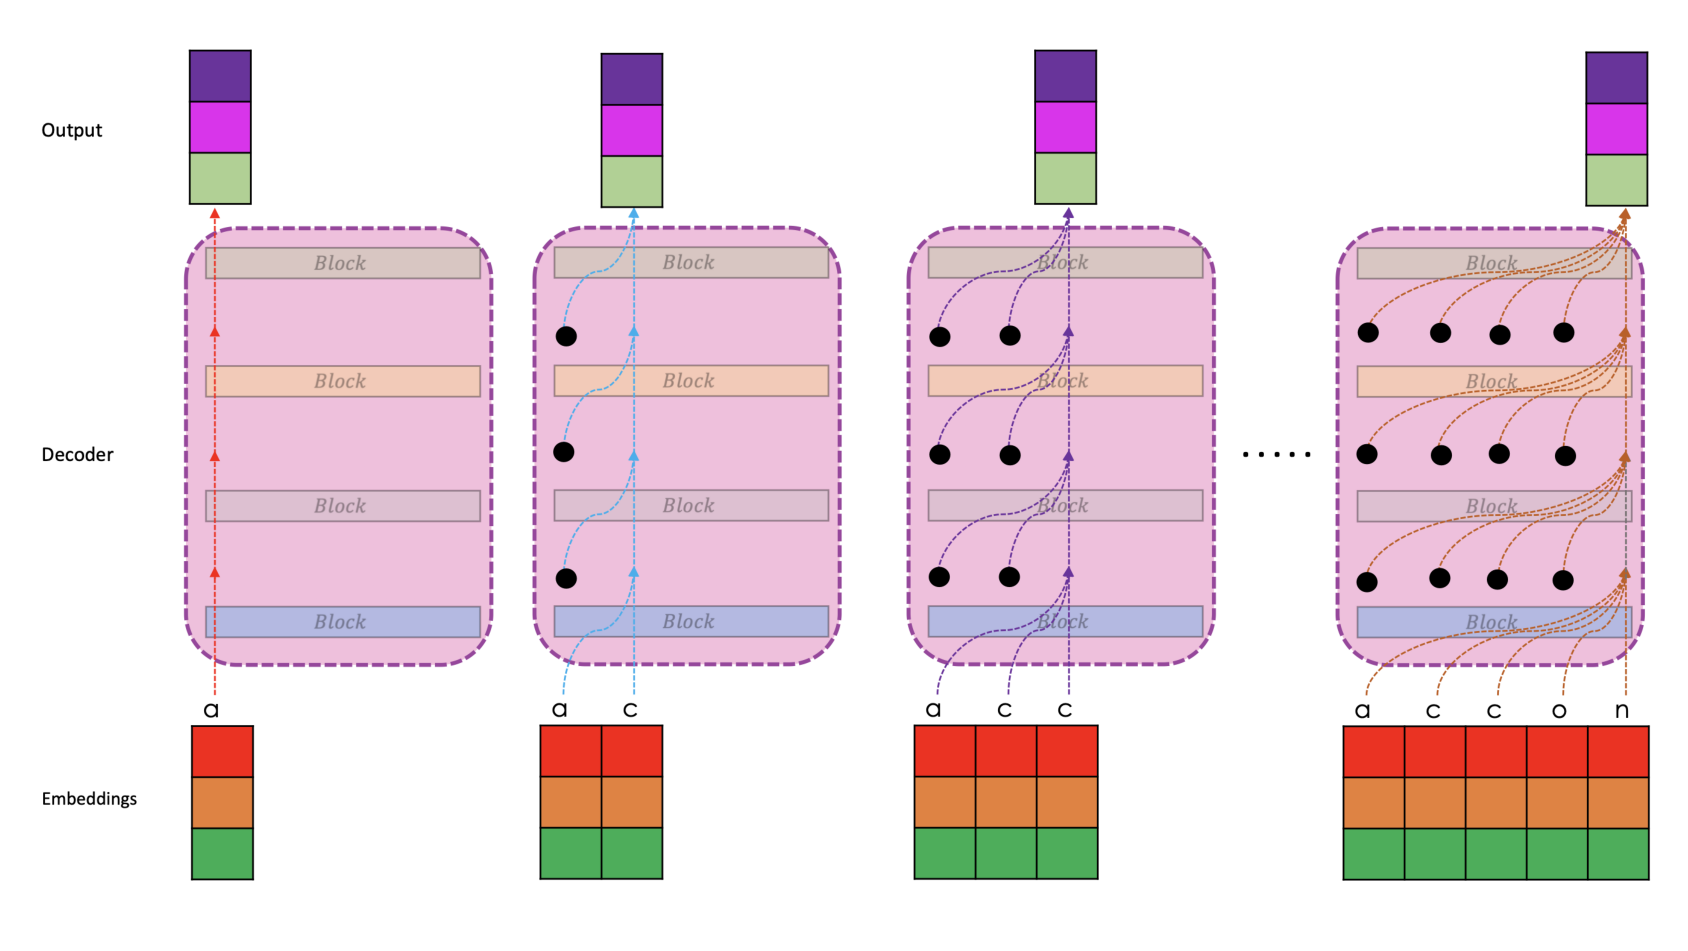

In [34]:
#| label: fig-gpt7
#| fig-cap: Inference
#| echo: false

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
plt.axis('off')
plt.imshow(plt.imread("images/decoding.png"))
plt.show()

The output of the model after training is shown.

In [30]:
#| panel: input
#| echo: false

#print("After training : ")
context = torch.zeros((1, 1), dtype=torch.long, device=device)
out = model.generate(context, max_new_tokens=500)
print(decode(out.squeeze().tolist()))


Whith the the one tI pordeeme,
Doy, he thervos, ap, andselieet mastes, ain so not will mice ry
jeve my of sor loveride meven of EI:
He Vis doght of ofeer
O,
That woud puked,
To a sabvert onLoy I hyoulows,
As bLost our to that em;
This; sJation evacem dather:
And not of the wi.
Clewayp prost.

LOLOUCENYIUS:
Aam farty:
The showell me empone the olee,
All douth vinds quise,
Inf thome blard'sf, coloumove'd Your that pis not and whe somen no
cinchis thris noting mmy dith.

MENRCENO:
Coushd. For pare 


The improvement achieved here, as compared to the bi-gram model, is remarkable. We have now developed a language model that can generate Shakespearean text, which is truly amazing. It is remarkable to witness the extent to which artificial intelligence has progressed.

# Conclusion

In this post, we began by implementing the bi-gram language model. Subsequently, we extended the code base to include the GPT model by incorporating two architectural modules. The first module is the communication module, where we introduced the masked attention, and the second module is the computation module, which consists of the feedforward network. We then stacked several such blocks to create the GPT architecture and trained it using cross-entropy loss, similar to the bi-gram model. The significant improvements in performance resulting from the introduction of these architectural changes are truly remarkable.